
... ***CURRENTLY UNDER DEVELOPMENT*** ...


### TODO
- INTRODUCIR PLOTEO SCA_VAL EN RECONSTRUCCIONES SEA Y SWELL
- VALIDACION VS BOYA AWAC + PLOTEO
- ¿PUEDE ACELERARSE RBF? ¿ESTAN AJUSTANDOSE VARIAS VECES LA MISMA?

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()


In [3]:
# input files: dataset, subset (MDA classification), and target (SWAN simulations output)

# sea 
wvs_sea_dataset_sim = db.Load_NEARSHORE_SIM_sea()
wvs_sea_dataset_hist = db.Load_NEARSHORE_HIST_sea()
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_sea_target = db.Load_NEARSHORE_TARGET_sea()

# swells 
wvs_swell_dataset_sim = db.Load_NEARSHORE_SIM_swell()
wvs_swell_dataset_hist = db.Load_NEARSHORE_HIST_swell()
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()
wvs_swell_target = db.Load_NEARSHORE_TARGET_swell()

# keep datasets n_sim column
sea_n_sim = wvs_sea_dataset_sim['n_sim']
swl_n_sim = wvs_swell_dataset_sim['n_sim']


# remove nans (if any) from subset and target
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swell_subset, wvs_swell_target = fix_target_nans(wvs_swell_subset, wvs_swell_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset_sim = wvs_sea_dataset_sim[vns_ds].values
wvs_sea_dataset_hist = wvs_sea_dataset_hist[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swell_dataset_sim = wvs_swell_dataset_sim[vns_ds].values
wvs_swell_dataset_hist = wvs_swell_dataset_hist[vns_ds].values
wvs_swell_subset = wvs_swell_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swell_target = wvs_swell_target[vns_tgt].values


remove nan data found at target:
         lat       lon  Hsig  Tm02  Dir  Dspr  TPsmoo
case                                                 
49    9.4165  167.4679   0.0   NaN  NaN   NaN     NaN


In [4]:
# RBF settings

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swell_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swell_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].to_dataframe().dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].to_dataframe().dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].to_dataframe().dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    return xr.Dataset.from_dataframe(rec_waves)
     


## RBF Reconstruct SEA Waves

In [5]:
# --------------------------------------
# RBF Interpolation

# TODO: activate + sca_val plot

# Simulated SEA waves
#sea_rec_sim = RBF_Reconstruction_sea(wvs_sea_dataset_sim)
#df_sea_recon_sim = pd.DataFrame(data=sea_rec_sim, columns=vns_tgt)
#df_sea_recon_sim['n_sim'] = sea_n_sim  # keep n_sim value


# Historical SEA waves
#sea_rec_hist = RBF_Reconstruction_sea(wvs_sea_dataset_hist)
#df_sea_recon_hist = pd.DataFrame(data=sea_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_sea(df_sea_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_sea(df_sea_recon_hist)



## RBF Reconstruct SWELL Waves

In [6]:
# --------------------------------------
# RBF Interpolation

# TODO: activate + sca_val plot

# Simulated SWELL waves
#swl_rec_sim = RBF_Reconstruction_swell(wvs_swell_dataset_sim)
#df_swl_recon_sim = pd.DataFrame(data=swl_rec_sim, columns=vns_tgt)
#df_swl_recon_sim['n_sim'] = swl_n_sim  # keep n_sim value


# Historical SWELL waves
#swl_rec_hist = RBF_Reconstruction_swell(wvs_swell_dataset_hist)
#df_swl_recon_hist = pd.DataFrame(data=swl_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_swell(df_swl_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_swell(df_swl_recon_hist)



## Load historical and simulated waves from Climate Emulator

In [7]:

# Load climate emulator historical waves (storms)
WVS_hist = db.Load_HIST_Complete_storms()
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp)


# Load cliamte emulator simulation waves (storms)
n_sims_DWTs = 10
l_WVS_sim = db.Load_SIM_Complete_storms(n_sims_DWTs)

# aggregate simulated waves and calculate AWL
for WVS_sim in l_WVS_sim:   
    WVS_a = Aggregate_WavesFamilies(WVS_sim)
    for vn in ['Hs', 'Tp', 'Dir']: 
        WVS_sim[vn] = WVS_a[vn]
    WVS_sim['AWL'] = AWL(WVS_sim.Hs, WVS_sim.Tp)


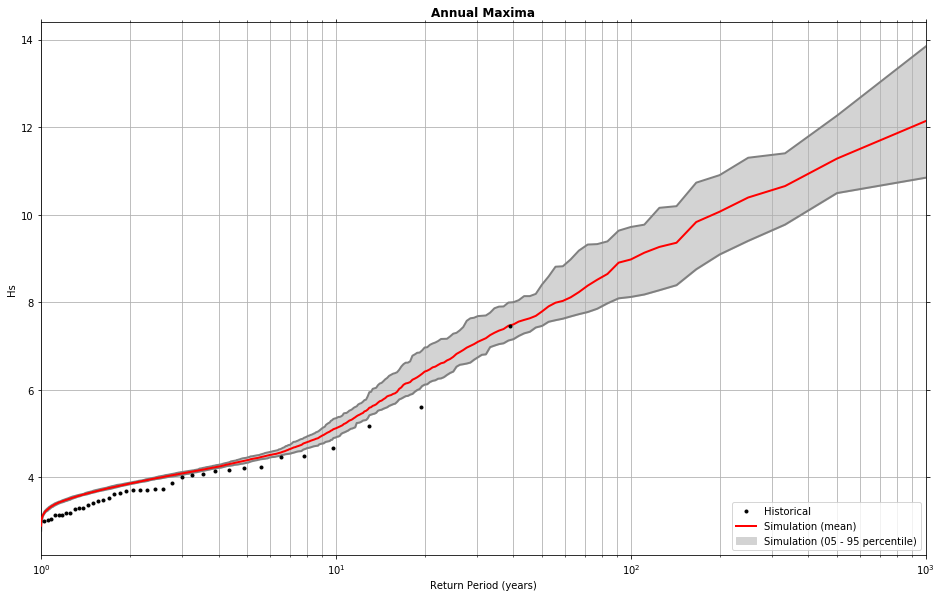

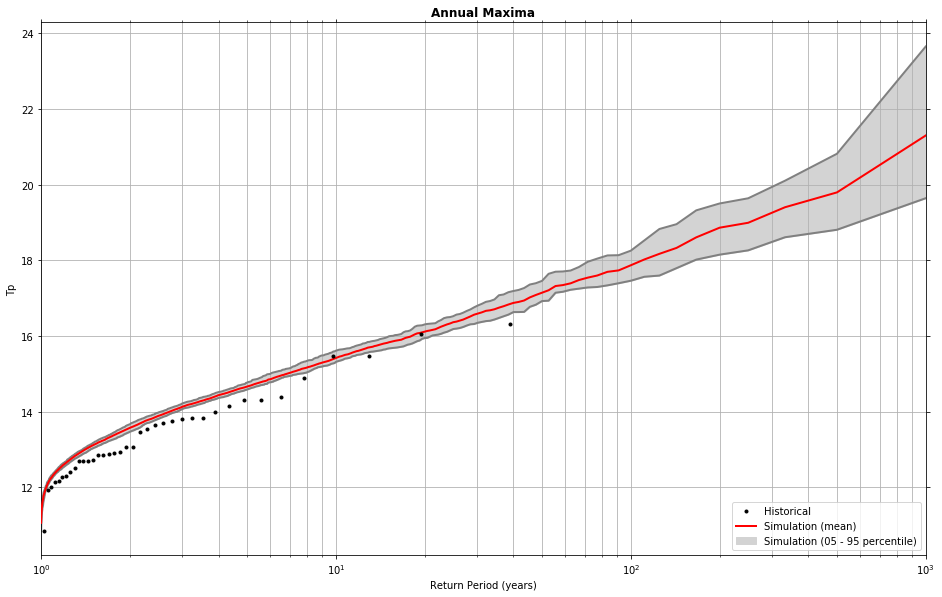

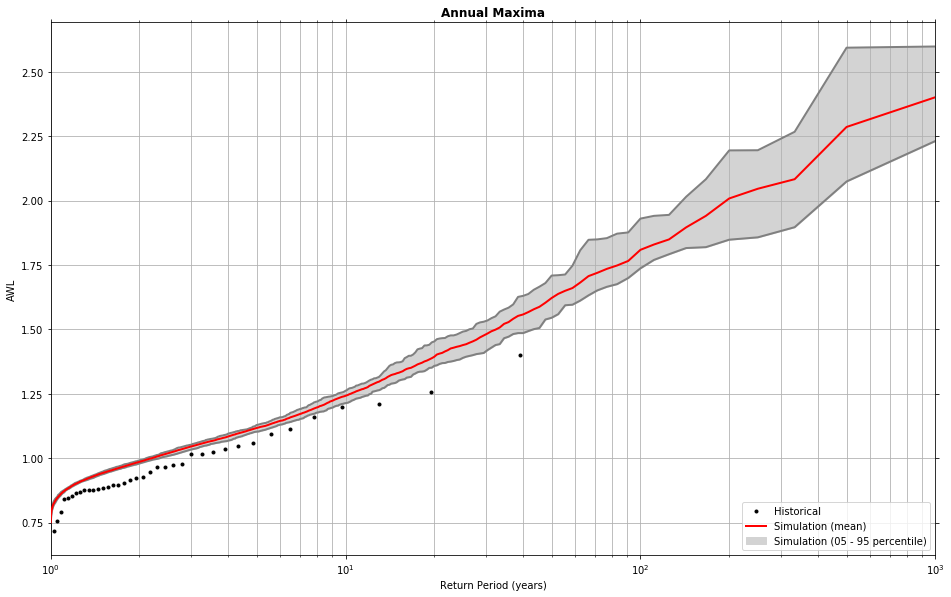

In [8]:
# compare historical and simulations annual maxima (for storms)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    


## RBF Reconstruct Historical storms time series and aggregate waves families

In [9]:
# Reconstruct waves by families and aggregate nearshore variables
rec_h = RBF_Reconstruction_families(WVS_hist)

WVS_HIST_rec = Aggregate_WavesFamilies(rec_h)
WVS_HIST_rec['AWL'] = AWL(WVS_HIST_rec.Hs, WVS_HIST_rec.Tp)


# store historical storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_HIST_storms(WVS_HIST_rec)


ix_scalar: 0,  optimization: 48.28 | interpolation: 0.29
ix_scalar: 1,  optimization: 98.39 | interpolation: 0.29
ix_directional: 2,  optimization: 86.61 | interpolation: 0.54
ix_scalar: 0,  optimization: 40.03 | interpolation: 0.45
ix_scalar: 1,  optimization: 88.38 | interpolation: 0.49
ix_directional: 2,  optimization: 93.68 | interpolation: 0.96
ix_scalar: 0,  optimization: 40.42 | interpolation: 0.51
ix_scalar: 1,  optimization: 89.19 | interpolation: 0.56
ix_directional: 2,  optimization: 93.30 | interpolation: 1.04



## RBF Reconstruct Simulation storms time series and aggregate waves families

In [10]:

l_sims_rec = []
for data in l_WVS_sim:
    
    # Reconstruct waves by families and aggregate nearshore variables
    rec_s = RBF_Reconstruction_families(data)
    
    WVS_SIM_rec = Aggregate_WavesFamilies(rec_s)
    WVS_SIM_rec['AWL'] = AWL(WVS_SIM_rec.Hs, WVS_SIM_rec.Tp)

    l_sims_rec.append(WVS_SIM_rec)
    
# store simulations storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_SIM_storms(l_sims_rec)


ix_scalar: 0,  optimization: 46.72 | interpolation: 4.79
ix_scalar: 1,  optimization: 98.47 | interpolation: 4.81
ix_directional: 2,  optimization: 87.03 | interpolation: 9.47
ix_scalar: 0,  optimization: 39.70 | interpolation: 12.84
ix_scalar: 1,  optimization: 87.46 | interpolation: 13.29
ix_directional: 2,  optimization: 92.86 | interpolation: 25.48
ix_scalar: 0,  optimization: 39.95 | interpolation: 14.06
ix_scalar: 1,  optimization: 87.62 | interpolation: 14.56
ix_directional: 2,  optimization: 93.47 | interpolation: 28.03
ix_scalar: 0,  optimization: 46.56 | interpolation: 4.81
ix_scalar: 1,  optimization: 96.53 | interpolation: 4.78
ix_directional: 2,  optimization: 87.27 | interpolation: 9.52
ix_scalar: 0,  optimization: 39.77 | interpolation: 12.62
ix_scalar: 1,  optimization: 87.41 | interpolation: 13.19
ix_directional: 2,  optimization: 92.78 | interpolation: 25.49
ix_scalar: 0,  optimization: 40.03 | interpolation: 14.05
ix_scalar: 1,  optimization: 87.48 | interpolation: 1

## Methodology Validation: Buoy comparison

In [11]:
# TODO: validate with AWAC + plot



## Methodology Validation: Annual Maxima

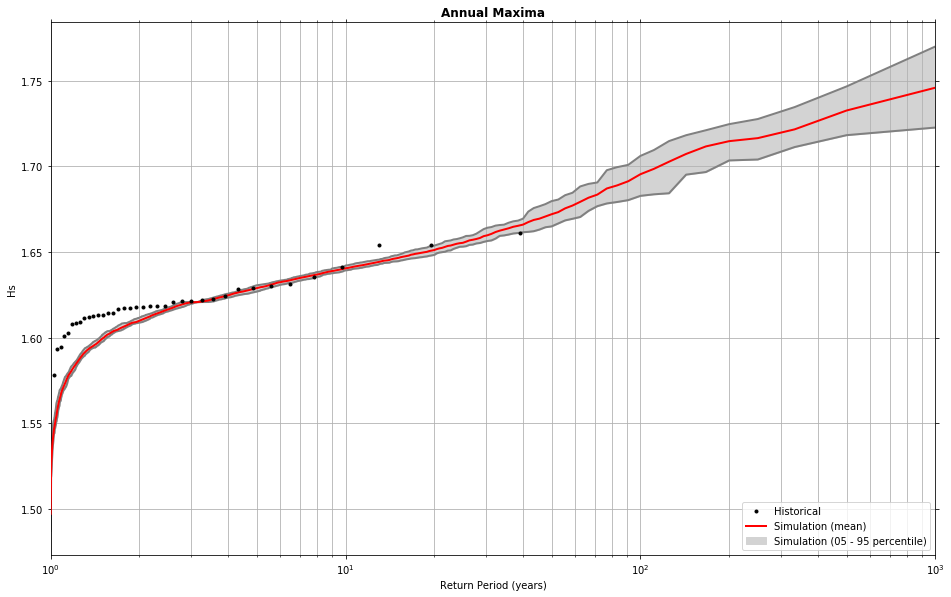

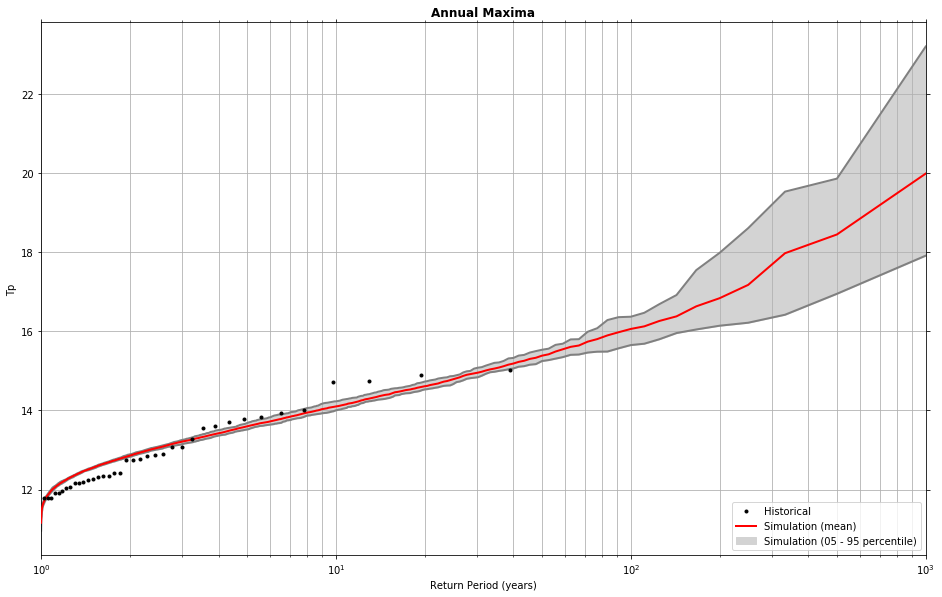

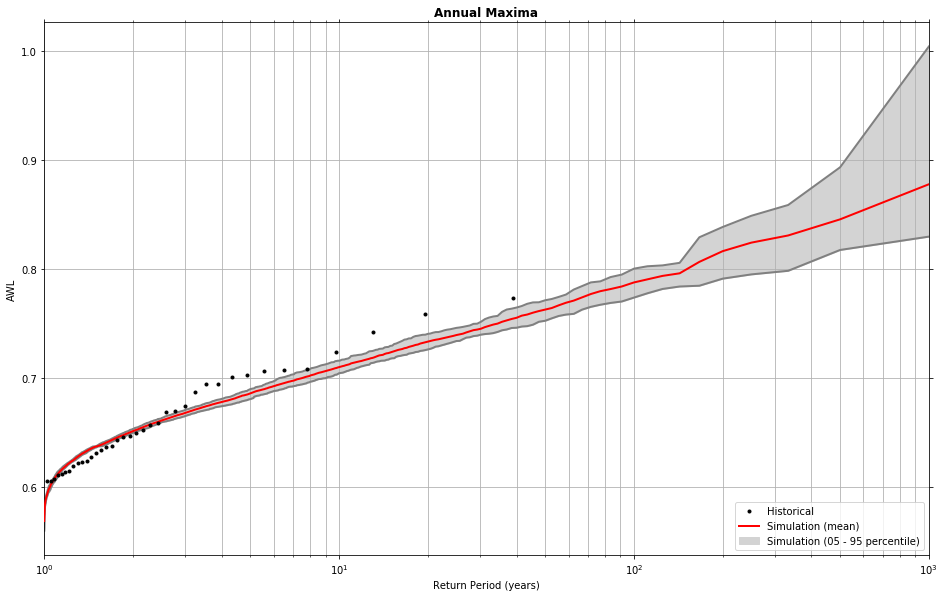

In [12]:
# compare historical and simulations reconstruction vars. annual maxima

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_HIST_rec[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_sims_rec], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    
